In [11]:
%load_ext autoreload
%autoreload 2

[rank: 0] Seed set to 42


Device: cuda:0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import torch
from pathlib import Path
import os
import json

import matplotlib.pyplot as plt
import pandas as pd

## Explore

In [3]:
meta_dir = '/data/vision/beery/scratch/data/iwildcam_unzipped/metadata/'

test_js = json.load(open(meta_dir+'iwildcam2022_test_information.json', 'r'))
gps_js = json.load(open(meta_dir+'gps_locations.json', 'r'))

# create (lat, long) tuples
test_locs = set([img['location'] for img in test_js['images']])
test_gpss = { loc: (gps_js[str(loc)]['latitude'], gps_js[str(loc)]['longitude']) for loc in test_locs if str(loc) in gps_js.keys() }

In [4]:
import folium

locations = list(test_gpss.values())

# Create a map centered around the first location
m = folium.Map()

# Add markers
for lat, lon in locations:
    folium.Marker([lat, lon]).add_to(m)

# Display the map
m

Cluster centers, most frequent locations, and cluster sizes:
Cluster 0:
 - Center: [-2.57252865 29.39772467]
 - Most frequent location: 292
 - Number of images: 556
 - Number of points in the cluster: 6
Cluster 1:
 - Center: [ -1.8839157  -76.76734288]
 - Most frequent location: 181
 - Number of images: 19
 - Number of points in the cluster: 7
Cluster 2:
 - Center: [ 0.39417042 36.87281146]
 - Most frequent location: 430
 - Number of images: 5076
 - Number of points in the cluster: 30
Cluster 3:
 - Center: [ 17.44710518 -89.30027934]
 - Most frequent location: 20
 - Number of images: 4282
 - Number of points in the cluster: 9
Cluster 4:
 - Center: [-19.83222836 -58.62684282]
 - Most frequent location: 4
 - Number of images: 74
 - Number of points in the cluster: 3


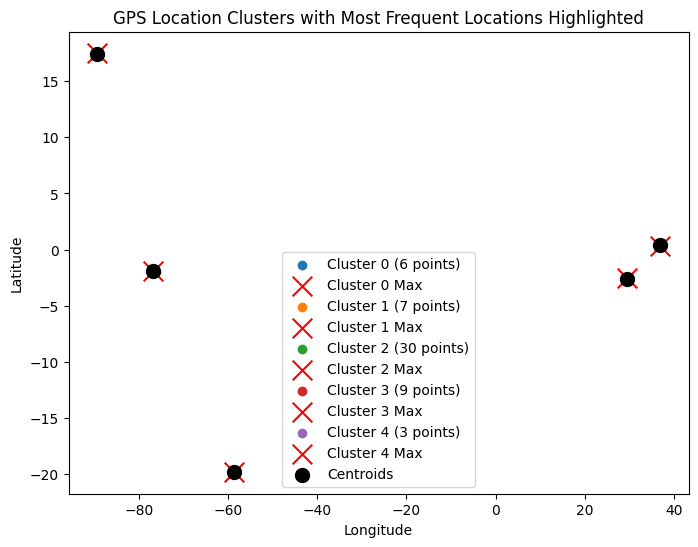

In [5]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import defaultdict

# Step 1: Aggregate image counts per location
location_image_counts = defaultdict(int)
for img in test_js['images']:
    location_image_counts[img['location']] += 1

# Step 2: Prepare GPS coordinates for clustering
locations = list(test_gpss.values())
location_ids = list(test_gpss.keys())  # Store the location IDs for reference
gps_coords = np.array(locations)

# Step 3: Perform clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(gps_coords)

# Step 4: Assign each location to its cluster
cluster_labels = kmeans.labels_
location_clusters = {loc_id: cluster for loc_id, cluster in zip(location_ids, cluster_labels)}

# Step 5: Find the most frequent location and count points in each cluster
cluster_max_locations = {}
cluster_sizes = defaultdict(int)  # To store the size of each cluster
for cluster in range(n_clusters):
    # Locations in the current cluster
    cluster_locations = [loc for loc, clust in location_clusters.items() if clust == cluster]
    cluster_sizes[cluster] = len(cluster_locations)  # Count points in the cluster
    
    # Find the most frequent location
    most_frequent_location = max(
        cluster_locations,
        key=lambda loc: location_image_counts[loc]
    )
    cluster_max_locations[cluster] = most_frequent_location

# Print the results
print("Cluster centers, most frequent locations, and cluster sizes:")
for cluster, location in cluster_max_locations.items():
    center = kmeans.cluster_centers_[cluster]
    print(f"Cluster {cluster}:")
    print(f" - Center: {center}")
    print(f" - Most frequent location: {location}")
    print(f" - Number of images: {location_image_counts[location]}")
    print(f" - Number of points in the cluster: {cluster_sizes[cluster]}")

# Optional: Visualize clusters and highlight the most frequent locations
plt.figure(figsize=(8, 6))
for cluster in range(n_clusters):
    cluster_points = gps_coords[cluster_labels == cluster]
    plt.scatter(cluster_points[:, 1], cluster_points[:, 0], label=f"Cluster {cluster} ({cluster_sizes[cluster]} points)")
    max_loc = test_gpss[cluster_max_locations[cluster]]
    plt.scatter(max_loc[1], max_loc[0], color='red', marker='x', s=200, label=f"Cluster {cluster} Max")

plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 0], 
            color='black', marker='o', label='Centroids', s=100)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("GPS Location Clusters with Most Frequent Locations Highlighted")
plt.legend()
plt.show()


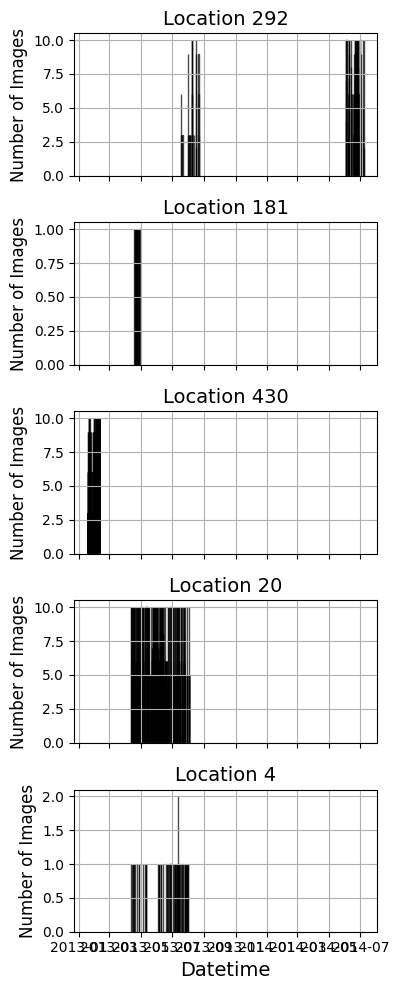

In [6]:
# Step 1: Extract relevant data for our_test_set_ids
our_test_set_ids = [292, 181, 430, 20, 4]

# Filter images for these location IDs
filtered_images = [
    img for img in test_js['images'] if img['location'] in our_test_set_ids
]

# Create a DataFrame for easier analysis
data = pd.DataFrame(filtered_images)

# Ensure datetime is in datetime format
data['datetime'] = pd.to_datetime(data['datetime'])

# Count the number of images per sequence ID
sequence_summary = (
    data.groupby(['location', 'seq_id'])
    .agg(
        seq_datetime=('datetime', 'min'),  # Use the earliest timestamp for the sequence
        num_images=('id', 'count')        # Count the number of images in the sequence
    )
    .reset_index()
)


# Step 2: Create subplots
num_locations = len(our_test_set_ids)
fig, axes = plt.subplots(num_locations, 1, figsize=(4, 2 * num_locations), sharex=True)

for i, location_id in enumerate(our_test_set_ids):
    loc_data = sequence_summary[sequence_summary['location'] == location_id]
    
    # Plot for the current location
    axes[i].bar(
        loc_data['seq_datetime'], 
        loc_data['num_images'], 
        width=0.05,  # Adjust width for better visuals
        color='skyblue',
        edgecolor='black',
        alpha=0.7
    )
    axes[i].set_title(f"Location {location_id}", fontsize=14)
    axes[i].set_ylabel("Number of Images", fontsize=12)
    axes[i].grid(True)

# Common x-axis label
plt.xlabel("Datetime", fontsize=14)
plt.tight_layout()
plt.show()


## Do stuff

In [13]:
from Iwildcam_Pretrain import IWildCamDataset

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

CHECKPOINT_PATH = "checkpoints/"
HEIGHT = 96
WIDTH = 160
PRECISION = 32


Device: cuda:0


In [ ]:
## fine-tune on each location:
##      full fine tuning
##      decoder frozen
##      all data at one time
## results will be:
##      bar chart, one bar per location of reconstruction error
##      or 
##      scatter plot, number of images vs. reconstruction error?

from Iwildcam_Pretrain import Autoencoder
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from sklearn.metrics import mean_squared_error

our_test_set_ids = [292, 181, 430, 20, 4]
latent_dim = 256

results = []

for loc_id in our_test_set_ids:
    test_set = IWildCamDataset(Path("/data/vision/beery/scratch/data/iwildcam_unzipped"), split="test")
    # test_set.cache_on_device_(device)
    test_set.data['images'] = [i for i in test_set.data['images'] if i['location'] == loc_id]
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=0)

   # Load model checkpoint or initialize model
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"iwildcam_{latent_dim}.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model for latent dim {latent_dim}, loading...")
        model = Autoencoder.load_from_checkpoint(pretrained_filename)
    else:
        raise Exception
    
    # Freeze decoder if specified
    freeze_decoder = True
    if freeze_decoder:
        for param in model.decoder.parameters():
            param.requires_grad = False
        print(f"Decoder frozen for location {loc_id}")

    # Define trainer
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, f"iwildcam_loc_{loc_id}"),
        accelerator="gpu" if str(device).startswith("cuda") else "cpu",
        precision=PRECISION,
        devices=1,
        max_epochs=100,
        callbacks=[
            ModelCheckpoint(save_weights_only=True),
            LearningRateMonitor("epoch")
        ]
    )

    # Train the model
    # Overfit to the test set
    trainer.fit(model, test_loader, test_loader)
    # trainer.save_checkpoint(pretrained_filename) # oops

    test_reconstruction_error = trainer.test(model=model, dataloaders=test_loader)[0]['test_loss']
    test_reconstruction_error /= len(test_loader) # TODO: I think what we get from test() is a sum over batches?

    # Store results
    results.append((loc_id, len(test_set.data['images']), test_reconstruction_error))

    # release memory
    del test_set
    del model
    del trainer
    torch.cuda.empty_cache()

# Step 6: Visualize the results
# Bar chart of reconstruction error by location
locations, num_images, errors = zip(*results)

# Bar chart
plt.figure(figsize=(10, 6))
plt.bar(locations, errors, color='skyblue', edgecolor='black')
plt.xlabel("Location ID", fontsize=12)
plt.ylabel("Reconstruction Error", fontsize=12)
plt.title("Reconstruction Error by Location", fontsize=14)
plt.grid(True)
plt.show()

# Scatter plot of number of images vs. reconstruction error
plt.figure(figsize=(10, 6))
plt.scatter(num_images, errors, color='red', edgecolor='black', s=100)
plt.xlabel("Number of Images", fontsize=12)
plt.ylabel("Reconstruction Error", fontsize=12)
plt.title("Number of Images vs. Reconstruction Error", fontsize=14)
plt.grid(True)
plt.show()

Found pretrained model for latent dim 256, loading...


/data/vision/beery/scratch/justin/envs/aecompression/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/vision/beery/scratch/justin/envs/aecompression ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Decoder frozen for location 292


You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode  | In sizes        | Out sizes      
--------------------------------------------------------------------------------
0 | encoder | Encoder | 4.0 M  | train | [2, 3, 160, 96] | [2, 256]       
1 | decoder | Decoder | 4.0 M  | train | [2, 256]        | [2, 3, 96, 160]
--------------------------------------------------------------------------------
4.0 M     Trainable params
4.0 M     Non-trainable params
8.1 M     Total params
32.339    Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/data/vision/beery/scratch/justin/envs/aecompression/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/data/vision/beery/scratch/justin/envs/aecompression/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/data/vision/beery/scratch/justin/envs/aecompression/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined